# Face Generation

In this project, I've defined and trained a DCGAN on a dataset of faces. My goal was to get a generator network to generate *new* images of faces that look as realistic as possible!

The project is broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, I was able to visualize the results of the trained Generator to see how it performs; my generated samples look like fairly realistic faces with small amounts of noise.

### Get the Data

I'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train my adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) I've been working with, and so, I've prepared to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, we should be left with a directory of data `processed_celeba_small/`

In [1]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we''re going to be generating faces, we won't need the annotations, we'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that we'll need to **transform** this data and create a **DataLoader**.

#### Complete the following `get_dataloader` function, such that it satisfies these requirements:

* The images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* The function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended to use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    
    train_data = datasets.ImageFolder(root=data_dir, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                              batch_size=batch_size,
                                              shuffle=True)
                                              
    return train_loader

## Create a DataLoader

#### Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* Decide on any reasonable `batch_size` parameter
* `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 64
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, let's view some images! There should be square images of somewhat-centered faces.

Note: We'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

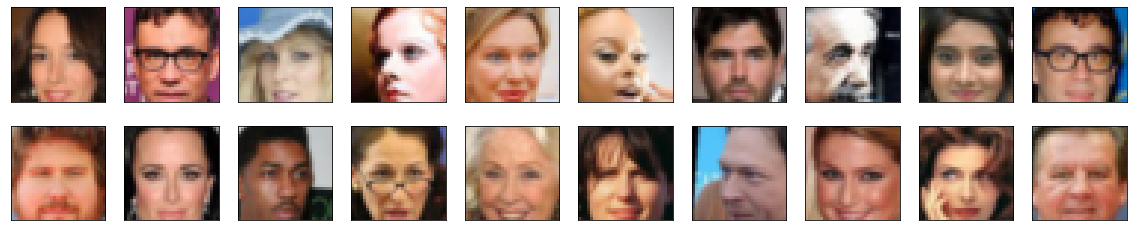

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process your image data and scale it to a pixel range of -1 to 1

We need to do a bit of pre-processing; we know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min    
    return x

In [7]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.9529)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

First, we will define the discriminator. This is a convolutional classifier like we've built before, only without any maxpooling layers. To deal with this complex data, it's suggested to use a deep network with **normalization**.

#### Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, 
                          out_channels, 
                          kernel_size, 
                          stride, 
                          padding, 
                          bias = False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim): #conv_dim=32
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()        
        self.conv_dim = conv_dim  
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*4*4)      
        x = self.fc(x)

        return x
    
    
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers=[]
    trans_conv = nn.ConvTranspose2d(in_channels, out_channels, 
                                   kernel_size, stride, padding, bias=False)
    
    layers.append(trans_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels)) 
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim     
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.tc1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.tc2 = deconv(conv_dim*2, conv_dim, 4)
        self.tc3 = deconv(conv_dim, 3, 4, batch_norm=False)      

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """    
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.tc1(x))
        x = F.relu(self.tc2(x))        
        x = F.tanh(self.tc3(x)) 
        
        return x

tests.test_generator(Generator)

Tests Passed


C:\Users\Yasmine\anaconda3\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help the models converge, we should initialize the weights of the convolutional and linear layers in the model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, let's define a weight initialization function that does just this!

We can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help complete this function.

#### Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Build complete network

Define the models' hyperparameters and instantiate the discriminator and generator from the classes defined above.

In [14]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 128

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=128, out_features=2048, bias=True)
  (tc1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tc2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Make sure that 
>* Models,
* Model inputs, and
* Loss function arguments

are moved to GPU, where appropriate.

In [16]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Complete real and fake loss functions


In [17]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    if train_on_gpu: 
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu: 
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for the models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

lr = 0.0002
beta1=0.4
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use the functions `real_loss` and `fake_loss` to help calculate the discriminator losses.

* We should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

#### Complete the training function

If we've moved our models to GPU, we'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)     
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                        
            d_real_pred = D(real_images)
            d_real_loss = real_loss(d_real_pred)
            
            fake_img = G(z)          
            d_fake_pred = D(fake_img)
            d_fake_loss = fake_loss(d_fake_pred)
            
            d_loss = d_fake_loss + d_real_loss
            
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
                
            fake_img = G(z)           
            g_pred = D(fake_img)
            g_loss = real_loss(g_pred)
            
            g_loss.backward()
            g_optimizer.step()
            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set the number of training epochs and train the GAN!

In [20]:
# set number of epochs 
n_epochs = 50

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.5661 | g_loss: 1.0205
Epoch [    1/   50] | d_loss: 0.1678 | g_loss: 2.7919
Epoch [    1/   50] | d_loss: 0.3241 | g_loss: 2.2409
Epoch [    1/   50] | d_loss: 0.7226 | g_loss: 6.4338
Epoch [    1/   50] | d_loss: 0.6439 | g_loss: 1.7401
Epoch [    1/   50] | d_loss: 0.4632 | g_loss: 2.2989
Epoch [    1/   50] | d_loss: 0.6576 | g_loss: 2.7403
Epoch [    1/   50] | d_loss: 0.7359 | g_loss: 2.4300
Epoch [    2/   50] | d_loss: 0.9783 | g_loss: 3.2251
Epoch [    2/   50] | d_loss: 0.6226 | g_loss: 2.4078
Epoch [    2/   50] | d_loss: 0.8520 | g_loss: 0.8547
Epoch [    2/   50] | d_loss: 0.7078 | g_loss: 1.7320
Epoch [    2/   50] | d_loss: 0.7712 | g_loss: 1.8746
Epoch [    2/   50] | d_loss: 1.4425 | g_loss: 2.7444
Epoch [    2/   50] | d_loss: 0.9486 | g_loss: 1.1240
Epoch [    2/   50] | d_loss: 0.8794 | g_loss: 2.4613
Epoch [    3/   50] | d_loss: 1.6499 | g_loss: 2.6380
Epoch [    3/   50] | d_loss: 1.0306 | g_loss: 0.7994
Epoch [    3/   50] | d_loss

Epoch [   20/   50] | d_loss: 0.9140 | g_loss: 1.0968
Epoch [   20/   50] | d_loss: 0.6121 | g_loss: 1.9368
Epoch [   20/   50] | d_loss: 0.4020 | g_loss: 2.4034
Epoch [   20/   50] | d_loss: 0.7134 | g_loss: 1.8973
Epoch [   20/   50] | d_loss: 0.4922 | g_loss: 2.2919
Epoch [   20/   50] | d_loss: 0.5465 | g_loss: 2.2935
Epoch [   20/   50] | d_loss: 0.5832 | g_loss: 1.9536
Epoch [   20/   50] | d_loss: 0.6455 | g_loss: 1.9093
Epoch [   21/   50] | d_loss: 0.8037 | g_loss: 2.7640
Epoch [   21/   50] | d_loss: 0.7631 | g_loss: 2.8621
Epoch [   21/   50] | d_loss: 2.2847 | g_loss: 0.1463
Epoch [   21/   50] | d_loss: 1.0424 | g_loss: 3.2996
Epoch [   21/   50] | d_loss: 0.8221 | g_loss: 1.2834
Epoch [   21/   50] | d_loss: 0.5946 | g_loss: 2.3111
Epoch [   21/   50] | d_loss: 1.1601 | g_loss: 0.9506
Epoch [   21/   50] | d_loss: 0.7453 | g_loss: 2.6160
Epoch [   22/   50] | d_loss: 0.9423 | g_loss: 0.8930
Epoch [   22/   50] | d_loss: 0.9081 | g_loss: 0.9615
Epoch [   22/   50] | d_loss

Epoch [   39/   50] | d_loss: 0.7171 | g_loss: 4.3661
Epoch [   39/   50] | d_loss: 0.4899 | g_loss: 2.0769
Epoch [   39/   50] | d_loss: 0.4981 | g_loss: 2.5154
Epoch [   39/   50] | d_loss: 0.3832 | g_loss: 2.6174
Epoch [   39/   50] | d_loss: 0.8542 | g_loss: 2.8017
Epoch [   39/   50] | d_loss: 0.4474 | g_loss: 1.9373
Epoch [   39/   50] | d_loss: 0.4315 | g_loss: 2.4762
Epoch [   39/   50] | d_loss: 0.3491 | g_loss: 2.4177
Epoch [   40/   50] | d_loss: 0.4966 | g_loss: 2.2148
Epoch [   40/   50] | d_loss: 0.5495 | g_loss: 1.7090
Epoch [   40/   50] | d_loss: 0.3903 | g_loss: 2.2507
Epoch [   40/   50] | d_loss: 0.5917 | g_loss: 4.7112
Epoch [   40/   50] | d_loss: 0.4103 | g_loss: 3.3677
Epoch [   40/   50] | d_loss: 0.3288 | g_loss: 2.3732
Epoch [   40/   50] | d_loss: 0.8838 | g_loss: 5.9320
Epoch [   40/   50] | d_loss: 0.4957 | g_loss: 3.3715
Epoch [   41/   50] | d_loss: 0.4241 | g_loss: 2.3870
Epoch [   41/   50] | d_loss: 0.5137 | g_loss: 1.7918
Epoch [   41/   50] | d_loss

C:\Users\Yasmine\anaconda3\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

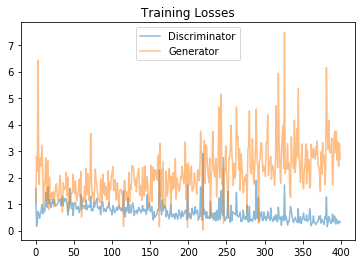

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and assess the strengths and weaknesses of the trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

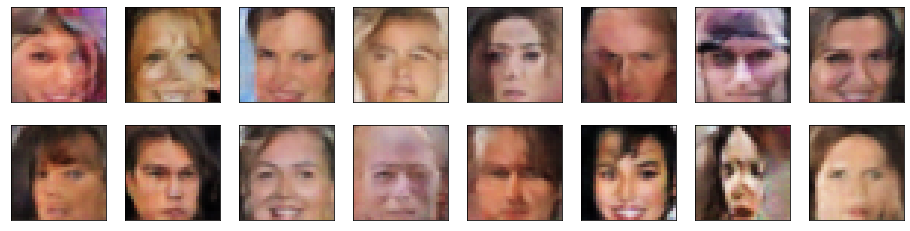

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?

The generated faces are convincing and fairly realistic, especially for faces that are white. Because the dataset consists of "celebrity" faces that are mostly white, we can conclude that the dataset introduces ethnicity bias. Including a diverse set of faces in the dataset can vastly improve the training of this model. To improve the model, we can consider enlarging the model size so that the model has the opportunity to learn more features in a data feature space. If complexity isn't an issue, we could also consider using a dataset that consists of images with higher quality/pixels so that the model can distinguish features to a higher degree. Furthermore, the model could benefit from longer training/epochs.

#### Opportunities for improvement:
**Discriminator**: 
* We are currently using even-sized filters. Instead of using even-sized filters, we can use odd-sized filters as the concept of a central or anchor pixel is more defined in the odd-sized filters. In odd-sized kernels, we have the same number of pixels on all sides from the anchor pixel. When using an even-sized filter, since this is not the case, it leads to aliasing errors. Refer to page 2 of [this document](https://www.cs.tau.ac.il/~dcor/Graphics/adv-slides/sampling05.pdf) for different kinds of aliasing errors. I would recommend using a kernel size of 5 for the network here.

* Batch Normalization is being used which helps stabilize the training. However, it should be used after the activation layer and not before it. In the original batch norm paper, Szgedy et al. used it before activation. However, the industry has since moved away from using it before activation and has started using it after the activation layer as it makes more statistical sense. The idea of Batch Norm is to provide inputs with mean 0 and very small variation for deeper layers. However, when used before the activation layer, the negative values are either clipped to zero or are turned to very very small values defeating its purpose.

**Generator**:
* Similar to the discriminator, we can avoid using even-sized filters in the first hidden layer.

* We can add more convolution transpose layers. Using a simple 3-layer generator is not going to help generate better images. Apart from this, generators which are sufficiently larger than the discriminator in terms of depth, help generate better samples. I would recommend adding at least 2 more layers to the generator. In order to accommodate more layers, I would recommend starting with a bigger dense layer (preferably 7x7x512 or 7x7x1024).

* We can use a stride of 1 in the last layer to avoid checkerboard-like artifacts in the generated images. Read more about the phenomenon in [this blog post](https://distill.pub/2016/deconv-checkerboard/).